
==== SVM Results ====
Accuracy: 0.9750
Sensitivity (Recall): 0.7500
Specificity: 1.0000
F1 Score: 0.8571
RMSE: 0.1581
ROC AUC: 0.9861

==== Random Forest Results ====
Accuracy: 0.9750
Sensitivity (Recall): 1.0000
Specificity: 0.9722
F1 Score: 0.8889
RMSE: 0.1581
ROC AUC: 0.9896

==== XGBoost Results ====
Accuracy: 0.9500
Sensitivity (Recall): 0.7500
Specificity: 0.9722
F1 Score: 0.7500
RMSE: 0.2236
ROC AUC: 0.9097


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:22:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


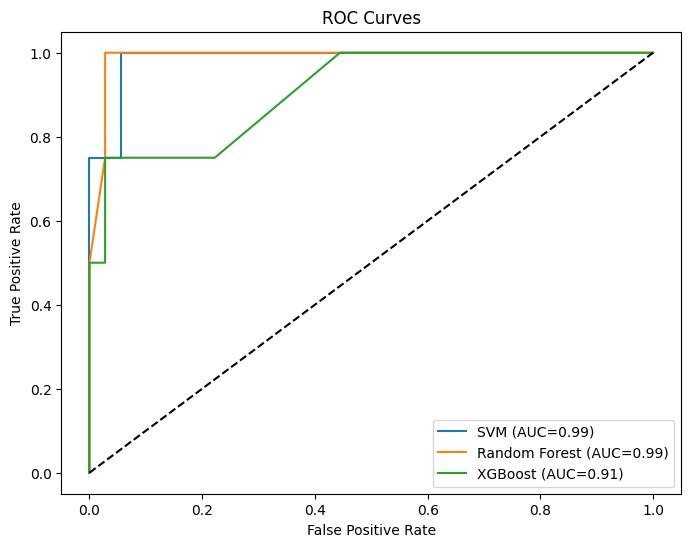

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, recall_score, confusion_matrix, f1_score,
    mean_squared_error, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# =========================
# 1. Load dataset
# =========================
data = pd.read_csv("pseudomonas_amr_sample.csv")

# Assuming the last column is the target (modify if needed)
X = data.drop(['sample_id', 'overall_label', 'year'], axis=1)
y = data['overall_label']

# Encode categorical target if necessary
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(include=np.number).columns

# Create a column transformer for one-hot encoding and scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough' # Keep other columns (shouldn't be any after splitting)
)

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

# =========================
# 2. Helper function
# =========================
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    f1 = f1_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    print(f"\n==== {model_name} Results ====")
    print(f"Accuracy: {acc:.4f}")
    print(f"Sensitivity (Recall): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"RMSE: {rmse:.4f}")
    if roc_auc:
        print(f"ROC AUC: {roc_auc:.4f}")

    # Plot ROC curve if probabilities exist
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC={roc_auc:.2f})")

# =========================
# 3. Train & evaluate models
# =========================
plt.figure(figsize=(8,6))

# SVM (with probability estimates enabled)
svm_model = SVC(probability=True, kernel='rbf', random_state=42)
evaluate_model(svm_model, X_train, X_test, y_train, y_test, "SVM")

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model(rf_model, X_train, X_test, y_train, y_test, "Random Forest")

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
evaluate_model(xgb_model, X_train, X_test, y_train, y_test, "XGBoost")

# Finalize ROC plot
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

** 5 fold cross validation of all the metrices **

Class distribution in full dataset:
0    0.895
1    0.105
Name: proportion, dtype: float64

Class distribution in training set:
0    0.89375
1    0.10625
Name: proportion, dtype: float64

Class distribution in test set:
0    0.9
1    0.1
Name: proportion, dtype: float64

==== SVM Results (Train/Test Split) ====
Accuracy: 0.9750
Sensitivity (Recall): 0.7500
Specificity: 1.0000
F1 Score: 0.8571
RMSE: 0.1581
ROC AUC: 0.9861

==== SVM Results (5-Fold Cross Validation) ====
Accuracy: 0.9850 ± 0.0300
F1 Score: 0.9333 ± 0.1333
Sensitivity (Recall): 0.9200 ± 0.1600
Specificity: 0.9943 ± 0.0114
RMSE: 0.0548 ± 0.1095
ROC AUC: 0.9897 ± 0.0206

==== Random Forest Results (Train/Test Split) ====
Accuracy: 0.9750
Sensitivity (Recall): 1.0000
Specificity: 0.9722
F1 Score: 0.8889
RMSE: 0.1581
ROC AUC: 0.9896

==== Random Forest Results (5-Fold Cross Validation) ====
Accuracy: 0.9950 ± 0.0100
F1 Score: 0.9778 ± 0.0444
Sensitivity (Recall): 1.0000 ± 0.0000
Specificity: 0.9944 ± 0.0111
RMSE: 0.0316 ± 0.0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:02:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:02:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:02:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:02:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:02:28] WARNING: /w


==== XGBoost Results (5-Fold Cross Validation) ====
Accuracy: 0.9850 ± 0.0122
F1 Score: 0.9270 ± 0.0607
Sensitivity (Recall): 0.9100 ± 0.1114
Specificity: 0.9944 ± 0.0111
RMSE: 0.0949 ± 0.0775
ROC AUC: 0.9473 ± 0.0618


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:02:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:02:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:02:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:02:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


<Figure size 800x600 with 0 Axes>

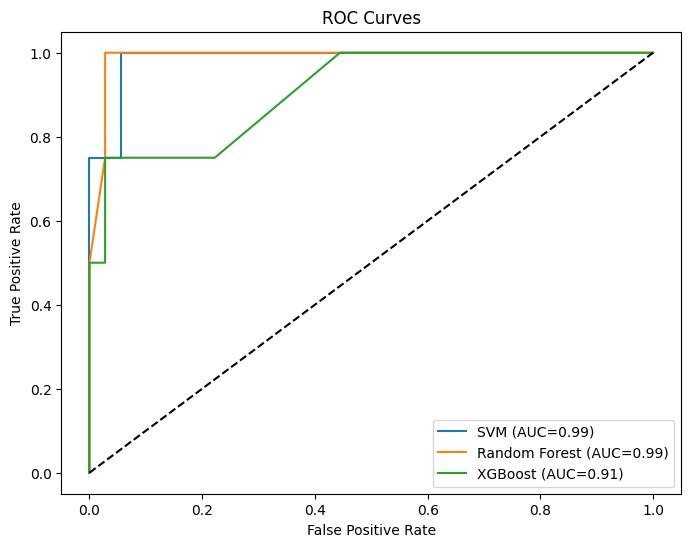

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, recall_score, confusion_matrix, f1_score,
    mean_squared_error, roc_auc_score, roc_curve, make_scorer
)
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# =========================
# 1. Load dataset
# =========================
data = pd.read_csv("pseudomonas_amr_sample.csv")

# Set features (X) and target (y)
X = data.drop(['sample_id', 'overall_label', 'year'], axis=1)
y = data['overall_label']

# Encode categorical target if necessary
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(include=np.number).columns

# Create a column transformer for one-hot encoding and scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough' # Keep other columns (shouldn't be any after splitting)
)

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

# Check class distribution
print("Class distribution in full dataset:")
print(pd.Series(y).value_counts(normalize=True))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

print("\nClass distribution in training set:")
print(pd.Series(y_train).value_counts(normalize=True))

print("\nClass distribution in test set:")
print(pd.Series(y_test).value_counts(normalize=True))

# =========================
# 2. Helper function for train/test evaluation
# =========================
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    f1 = f1_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    print(f"\n==== {model_name} Results (Train/Test Split) ====")
    print(f"Accuracy: {acc:.4f}")
    print(f"Sensitivity (Recall): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"RMSE: {rmse:.4f}")
    if roc_auc:
        print(f"ROC AUC: {roc_auc:.4f}")

    return y_prob # Return probabilities for ROC plotting

# =========================
# 3. Cross-validation helper with full metrics
# =========================
def cross_validate_model(model, X, y, model_name, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    acc_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    f1_scores = cross_val_score(model, X, y, cv=skf, scoring='f1')
    recall_scores = cross_val_score(model, X, y, cv=skf, scoring='recall')
    roc_auc_scores = cross_val_score(model, X, y, cv=skf, scoring='roc_auc')

    # Specificity and RMSE need custom scorers
    def specificity_scorer_func(y_true, y_pred):
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        return tn / (tn + fp)

    def rmse_scorer_func(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    specificity_scorer = make_scorer(specificity_scorer_func)
    rmse_scorer = make_scorer(rmse_scorer_func, greater_is_better=False)

    specificity_scores = cross_val_score(model, X, y, cv=skf, scoring=specificity_scorer)
    rmse_scores = cross_val_score(model, X, y, cv=skf, scoring=rmse_scorer)

    print(f"\n==== {model_name} Results ({cv}-Fold Cross Validation) ====")
    print(f"Accuracy: {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")
    print(f"F1 Score: {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")
    print(f"Sensitivity (Recall): {recall_scores.mean():.4f} ± {recall_scores.std():.4f}")
    print(f"Specificity: {specificity_scores.mean():.4f} ± {specificity_scores.std():.4f}")
    print(f"RMSE: {abs(rmse_scores.mean()):.4f} ± {rmse_scores.std():.4f}")
    print(f"ROC AUC: {roc_auc_scores.mean():.4f} ± {roc_auc_scores.std():.4f}")


# =========================
# 4. Train & evaluate models
# =========================
plt.figure(figsize=(8,6))

# SVM (with probability estimates enabled)
svm_model = SVC(probability=True, kernel='rbf', random_state=42)
svm_y_prob = evaluate_model(svm_model, X_train, X_test, y_train, y_test, "SVM")
cross_validate_model(svm_model, X_processed, y, "SVM", cv=5)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_y_prob = evaluate_model(rf_model, X_train, X_test, y_train, y_test, "Random Forest")
cross_validate_model(rf_model, X_processed, y, "Random Forest", cv=5)

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_y_prob = evaluate_model(xgb_model, X_train, X_test, y_train, y_test, "XGBoost")
cross_validate_model(xgb_model, X_processed, y, "XGBoost", cv=5)

# Finalize ROC plot
plt.figure(figsize=(8,6))
if svm_y_prob is not None:
    fpr, tpr, _ = roc_curve(y_test, svm_y_prob)
    plt.plot(fpr, tpr, label=f"SVM (AUC={roc_auc_score(y_test, svm_y_prob):.2f})")
if rf_y_prob is not None:
    fpr, tpr, _ = roc_curve(y_test, rf_y_prob)
    plt.plot(fpr, tpr, label=f"Random Forest (AUC={roc_auc_score(y_test, rf_y_prob):.2f})")
if xgb_y_prob is not None:
    fpr, tpr, _ = roc_curve(y_test, xgb_y_prob)
    plt.plot(fpr, tpr, label=f"XGBoost (AUC={roc_auc_score(y_test, xgb_y_prob):.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

**Evaluation of statistical metrices including Cohens Kappa**


==== SVM Results (with Cohen's Kappa) ====
Accuracy: 0.9750
Sensitivity (Recall): 0.7500
Specificity: 1.0000
F1 Score: 0.8571
RMSE: 0.1581
ROC AUC: 0.9861
Cohen's Kappa: 0.8438

==== Random Forest Results (with Cohen's Kappa) ====
Accuracy: 0.9750
Sensitivity (Recall): 1.0000
Specificity: 0.9722
F1 Score: 0.8889
RMSE: 0.1581
ROC AUC: 0.9896
Cohen's Kappa: 0.8750

==== XGBoost Results (with Cohen's Kappa) ====
Accuracy: 0.9500
Sensitivity (Recall): 0.7500
Specificity: 0.9722
F1 Score: 0.7500
RMSE: 0.2236
ROC AUC: 0.9097
Cohen's Kappa: 0.7222


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:07:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


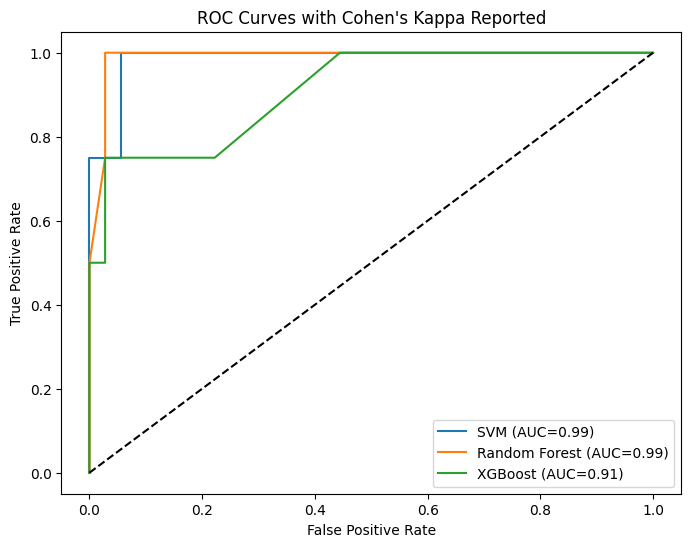

In [6]:
from sklearn.metrics import cohen_kappa_score

def evaluate_model_with_kappa(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Standard metrics
    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    f1 = f1_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    # NEW: Cohen's Kappa
    kappa = cohen_kappa_score(y_test, y_pred)

    print(f"\n==== {model_name} Results (with Cohen's Kappa) ====")
    print(f"Accuracy: {acc:.4f}")
    print(f"Sensitivity (Recall): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"RMSE: {rmse:.4f}")
    if roc_auc:
        print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")

    # Plot ROC curve if probabilities exist
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC={roc_auc:.2f})")

# =========================
# Run models with Cohen’s Kappa
# =========================
plt.figure(figsize=(8,6))

svm_model = SVC(probability=True, kernel='rbf', random_state=42)
evaluate_model_with_kappa(svm_model, X_train, X_test, y_train, y_test, "SVM")

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model_with_kappa(rf_model, X_train, X_test, y_train, y_test, "Random Forest")

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
evaluate_model_with_kappa(xgb_model, X_train, X_test, y_train, y_test, "XGBoost")

# Finalize ROC plot
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves with Cohen's Kappa Reported")
plt.legend()
plt.show()


**Cohens kappa and other metrices involving  just train/test/split and 5 fold cross validation**


==== SVM Results (Train/Test Split) ====
Accuracy: 0.9750
Sensitivity (Recall): 0.7500
Specificity: 1.0000
F1 Score: 0.8571
RMSE: 0.1581
ROC AUC: 0.9861
Cohen's Kappa: 0.8438

==== SVM Results (5-Fold Cross Validation) ====
Accuracy: 0.9850 ± 0.0300
F1 Score: 0.9333 ± 0.1333
Sensitivity (Recall): 0.9200 ± 0.1600
Specificity: 0.9943 ± 0.0114
RMSE: 0.0548 ± 0.1095
ROC AUC: 0.9897 ± 0.0206
Cohen's Kappa: 0.9250 ± 0.1500

==== Random Forest Results (Train/Test Split) ====
Accuracy: 0.9750
Sensitivity (Recall): 1.0000
Specificity: 0.9722
F1 Score: 0.8889
RMSE: 0.1581
ROC AUC: 0.9896
Cohen's Kappa: 0.8750

==== Random Forest Results (5-Fold Cross Validation) ====
Accuracy: 0.9950 ± 0.0100
F1 Score: 0.9778 ± 0.0444
Sensitivity (Recall): 1.0000 ± 0.0000
Specificity: 0.9944 ± 0.0111
RMSE: 0.0316 ± 0.0632
ROC AUC: 1.0000 ± 0.0000
Cohen's Kappa: 0.9750 ± 0.0500

==== XGBoost Results (Train/Test Split) ====
Accuracy: 0.9500
Sensitivity (Recall): 0.7500
Specificity: 0.9722
F1 Score: 0.7500
RMSE: 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:11:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:11:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:11:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:11:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:11:12] WARNING: /w


==== XGBoost Results (5-Fold Cross Validation) ====
Accuracy: 0.9850 ± 0.0122
F1 Score: 0.9270 ± 0.0607
Sensitivity (Recall): 0.9100 ± 0.1114
Specificity: 0.9944 ± 0.0111
RMSE: 0.0949 ± 0.0775
ROC AUC: 0.9473 ± 0.0618
Cohen's Kappa: 0.9187 ± 0.0673


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:11:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:11:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


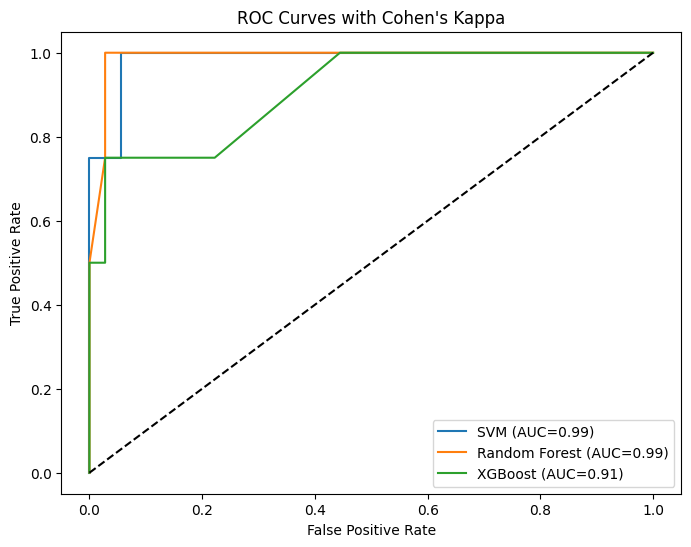

In [8]:
from sklearn.metrics import cohen_kappa_score, make_scorer

# =========================
# Train/Test Evaluation with Cohen's Kappa
# =========================
def evaluate_model_with_kappa(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    f1 = f1_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    kappa = cohen_kappa_score(y_test, y_pred)

    print(f"\n==== {model_name} Results (Train/Test Split) ====")
    print(f"Accuracy: {acc:.4f}")
    print(f"Sensitivity (Recall): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"RMSE: {rmse:.4f}")
    if roc_auc:
        print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")

    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC={roc_auc:.2f})")

# =========================
# Cross-validation with Cohen's Kappa
# =========================
def cross_validate_with_kappa(model, X, y, model_name, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    acc_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    f1_scores = cross_val_score(model, X, y, cv=skf, scoring='f1')
    recall_scores = cross_val_score(model, X, y, cv=skf, scoring='recall')
    roc_auc_scores = cross_val_score(model, X, y, cv=skf, scoring='roc_auc')

    # Custom scorers
    def specificity(y_true, y_pred):
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        return tn / (tn + fp)

    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    specificity_scorer = make_scorer(specificity)
    rmse_scorer = make_scorer(rmse, greater_is_better=False)
    kappa_scorer = make_scorer(cohen_kappa_score)

    specificity_scores = cross_val_score(model, X, y, cv=skf, scoring=specificity_scorer)
    rmse_scores = cross_val_score(model, X, y, cv=skf, scoring=rmse_scorer)
    kappa_scores = cross_val_score(model, X, y, cv=skf, scoring=kappa_scorer)

    print(f"\n==== {model_name} Results ({cv}-Fold Cross Validation) ====")
    print(f"Accuracy: {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")
    print(f"F1 Score: {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")
    print(f"Sensitivity (Recall): {recall_scores.mean():.4f} ± {recall_scores.std():.4f}")
    print(f"Specificity: {specificity_scores.mean():.4f} ± {specificity_scores.std():.4f}")
    print(f"RMSE: {abs(rmse_scores.mean()):.4f} ± {rmse_scores.std():.4f}")
    print(f"ROC AUC: {roc_auc_scores.mean():.4f} ± {roc_auc_scores.std():.4f}")
    print(f"Cohen's Kappa: {kappa_scores.mean():.4f} ± {kappa_scores.std():.4f}")


# =========================
# Run Models
# =========================
plt.figure(figsize=(8,6))

svm_model = SVC(probability=True, kernel='rbf', random_state=42)
evaluate_model_with_kappa(svm_model, X_train, X_test, y_train, y_test, "SVM")
cross_validate_with_kappa(svm_model, X_processed, y, "SVM", cv=5)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model_with_kappa(rf_model, X_train, X_test, y_train, y_test, "Random Forest")
cross_validate_with_kappa(rf_model, X_processed, y, "Random Forest", cv=5)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
evaluate_model_with_kappa(xgb_model, X_train, X_test, y_train, y_test, "XGBoost")
cross_validate_with_kappa(xgb_model, X_processed, y, "XGBoost", cv=5)

# Finalize ROC plot
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves with Cohen's Kappa")
plt.legend()
plt.show()

**Bar plot comparing Cohen’s Kappa across models from 5 fold cross validation**

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:13:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:13:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:13:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:13:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:13:01] WARNING: /w

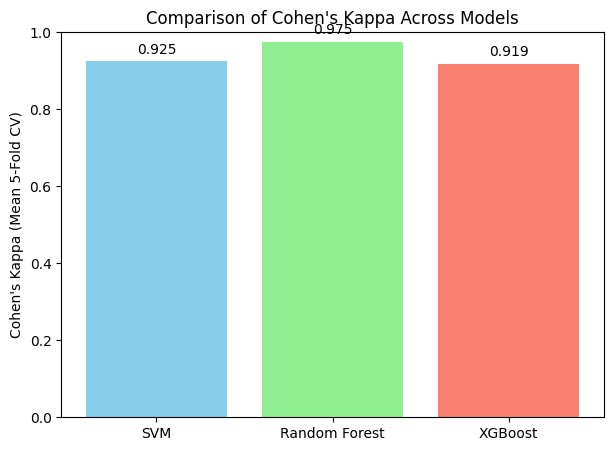

In [10]:
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt

# =========================
# Bar plot of Cohen's Kappa across models
# =========================

models = ["SVM", "Random Forest", "XGBoost"]
kappa_scores = []

# Collect Cohen's Kappa from 5-fold CV
for model, name in zip(
    [svm_model, rf_model, xgb_model],
    models
):
    kappa_scorer = make_scorer(cohen_kappa_score)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_processed, y, cv=skf, scoring=kappa_scorer)
    kappa_scores.append(scores.mean())

# Plot
plt.figure(figsize=(7,5))
plt.bar(models, kappa_scores, color=["skyblue","lightgreen","salmon"])
plt.ylabel("Cohen's Kappa (Mean 5-Fold CV)")
plt.title("Comparison of Cohen's Kappa Across Models")
plt.ylim(0, 1)  # Kappa ranges from -1 to 1, but usually 0–1
for i, score in enumerate(kappa_scores):
    plt.text(i, score + 0.02, f"{score:.3f}", ha='center')
plt.show()

**Similar bar chart for all key metrics (Accuracy, F1, Recall, Specificity, AUC, Cohens kappa) 5 fold cross validation,**

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:16:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:16:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:16:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:16:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:16:10] WARNING: /w

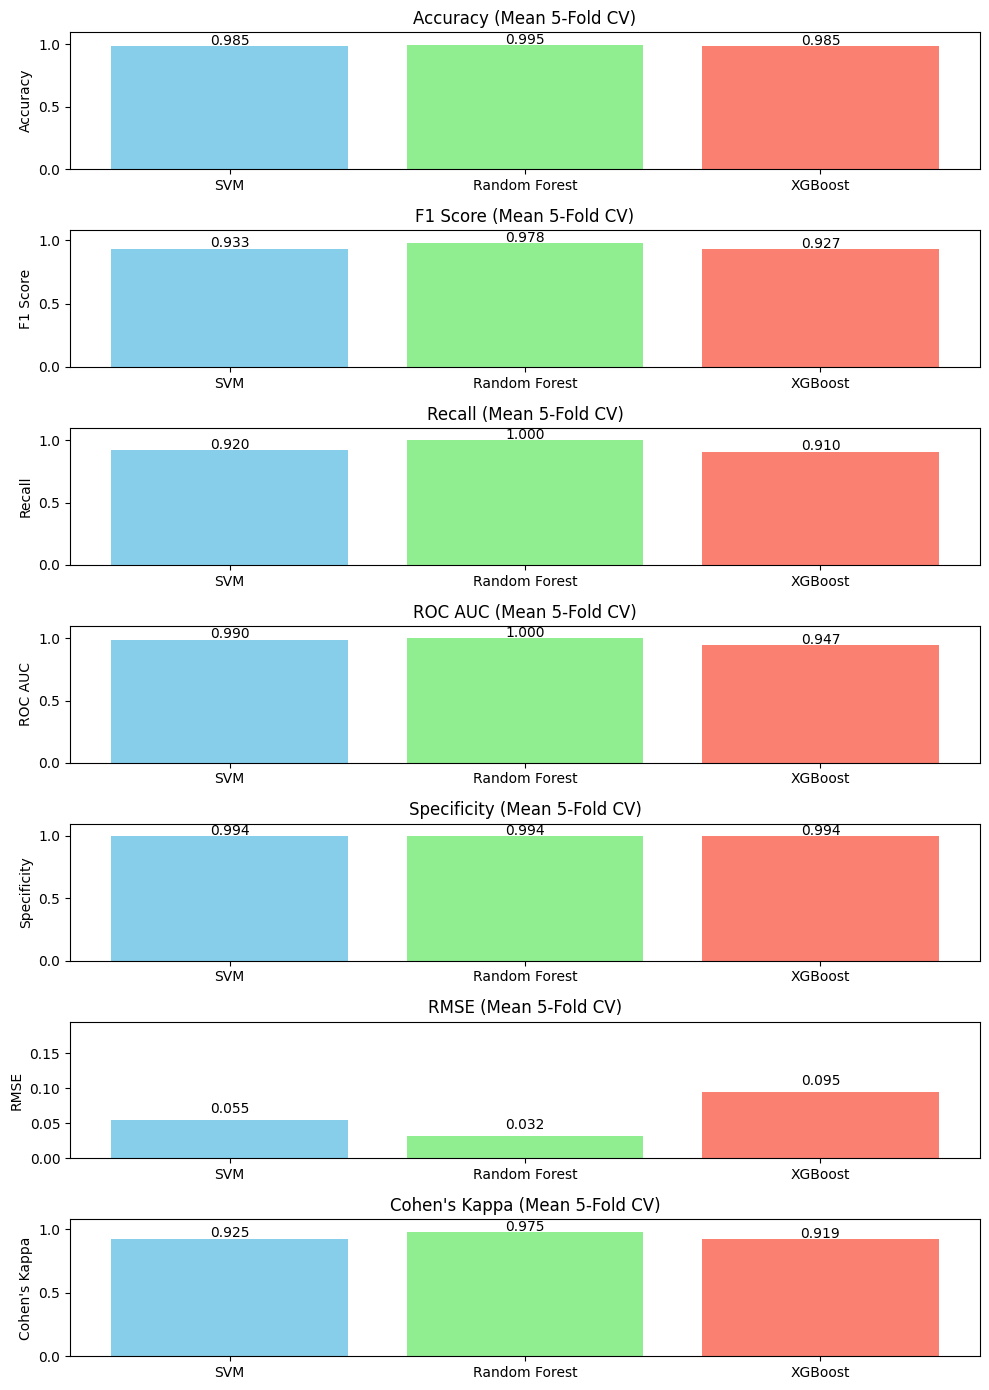

In [12]:
from sklearn.metrics import cohen_kappa_score, make_scorer, confusion_matrix, accuracy_score, f1_score, recall_score, roc_auc_score, mean_squared_error
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Assuming X_processed and y are already defined from previous cells

# =========================
# Collect metrics from 5-fold CV for all models
# =========================
metrics = {
    "Accuracy": "accuracy",
    "F1 Score": "f1",
    "Recall": "recall",
    "ROC AUC": "roc_auc"
}

# Custom scorers
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) != 0 else 0 # Add check for division by zero

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

specificity_scorer = make_scorer(specificity)
rmse_scorer = make_scorer(rmse, greater_is_better=False)
kappa_scorer = make_scorer(cohen_kappa_score)

custom_metrics = {
    "Specificity": specificity_scorer,
    "RMSE": rmse_scorer,
    "Cohen's Kappa": kappa_scorer
}

all_results = {m: [] for m in list(metrics.keys()) + list(custom_metrics.keys())}
model_names = ["SVM", "Random Forest", "XGBoost"]

models = [
    SVC(probability=True, kernel='rbf', random_state=42),
    RandomForestClassifier(n_estimators=100, random_state=42),
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model, name in zip(models, model_names):
    # Standard metrics
    for m_name, scorer in metrics.items():
        scores = cross_val_score(model, X_processed, y, cv=skf, scoring=scorer)
        all_results[m_name].append(scores.mean())

    # Custom metrics
    for m_name, scorer in custom_metrics.items():
        scores = cross_val_score(model, X_processed, y, cv=skf, scoring=scorer)
        # Take absolute mean for RMSE (since scorer returns negative value for lower-is-better)
        all_results[m_name].append(abs(scores.mean()) if m_name == "RMSE" else scores.mean())

# =========================
# Plot bar charts for each metric
# =========================
num_metrics = len(all_results)
plt.figure(figsize=(10, num_metrics * 2)) # Adjusted figure size

for i, (metric, values) in enumerate(all_results.items(), 1):
    plt.subplot(num_metrics, 1, i)
    plt.bar(model_names, values, color=["skyblue", "lightgreen", "salmon"])
    plt.ylabel(metric)
    plt.title(f"{metric} (Mean 5-Fold CV)")
    plt.ylim(0, max(values) + 0.1 if max(values) < 1 else 1.1) # Adjust ylim for metrics that can exceed 1
    for j, v in enumerate(values):
        plt.text(j, v + 0.01, f"{v:.3f}", ha='center')

plt.tight_layout()
plt.show()